In [1]:
import numpy as np
import scipy.stats as sps
from glob import glob
import matplotlib.pyplot as plt
import uproot as ur
import root_numpy as rtnp
import ROOT as rt
import sys, yaml, os
sys.path.append('../lib')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, SetMaxToMaxHist, make_ratio_plot
from progressBar import ProgressBar

from analysis_utilities import drawOnCMSCanvas, getEff

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText = ' '*7+'Internal Simulation'

donotdelete = []

Welcome to JupyROOT 6.12/07


In [2]:
rt.gErrorIgnoreLevel = rt.kError
rt.RooMsgService.instance().setGlobalKillBelow(rt.RooFit.ERROR)

In [3]:
site_loc_conf = '/mnt/hadoop/store/user/ocerri'
sampleFile = '/storage/user/ocerri/work/CMSSW_10_2_3/src/ntuplizer/BPH_RDntuplizer/production/samples.yml'
samples = yaml.load(open(sampleFile))['samples']
class Bauble(object):
    def __init__(self, in_sample, 
                 candLoc='/storage/user/ocerri/BPhysics/data/cmsMC_private/', 
                 candDir='ntuples_B2DstMu'):
        if not in_sample in samples.keys():
            raise
        self.sample = in_sample
        self.candLoc = candLoc
        self.candDir = candDir
        
        self.MINIAOD_dirs = []
        for part in samples[self.sample]['parts']:
            aux = glob(part)
            if len(aux) > 0:
                aux = os.path.dirname(part)
            else:
                aux = glob(site_loc_conf + part[:-38].replace('ocerri-','') + '/*/*')
            self.MINIAOD_dirs += aux

        self.full_name = samples[self.sample]['dataset']
        self.ntuples_dir = glob(os.path.join(self.candLoc, self.full_name, self.candDir))[0]
        
        f = os.path.join(self.ntuples_dir, 'effCAND.yaml')
        self.effCAND = yaml.load(open(f, 'r'))
        
        f = os.path.join(self.candLoc, self.full_name, 'effMCgenerator.yaml')
        self.effMC = yaml.load(open(f, 'r'))
        
        self.data = {}
        for fname in glob(os.path.join(self.ntuples_dir, 'skimmed/*.root')):
            k = os.path.basename(fname).replace('.root', '')
            self.data[k] = rtnp.root2array(fname)

In [4]:
dset = {}

dset['mu_0'] = Bauble('B0_MuNuDmst_PU0')
dset['muHQET_0'] = Bauble('B0_MuNuDmst_HQETcentral_PU0')

# Preliminary study

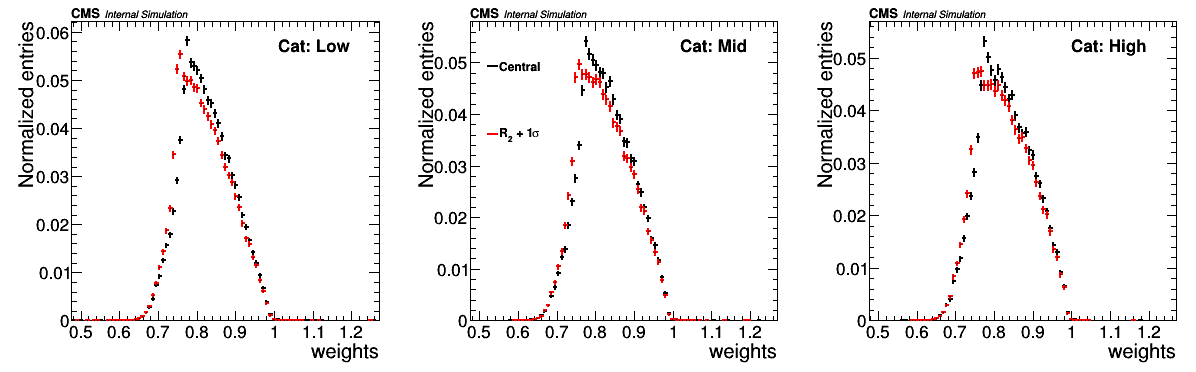

In [5]:
c = rt.TCanvas('c', 'c', 1200, 400)
c.Divide(3)
dnd = []
for ic, cat in enumerate(['Low', 'Mid', 'High']):
    a = dset['mu_0'].data[cat]
    h = create_TH1D(a['wh_CLNCentral'], axis_title=['weights', 'Normalized entries'], scale_histo=1./a.shape[0])
    h2 = create_TH1D(a['wh_CLNR2Up'], scale_histo=1./a.shape[0])
    h2.SetLineColor(2)
    
    pad = c.cd(ic+1)
    h.Draw()
    h2.Draw('same')
    text = rt.TText(0.9, 0.9, 'Cat: '+cat)
    text.SetTextAlign(33)
    text.SetNDC()
    text.Draw()
    dnd.append([h, h2, text])
    CMS_lumi.CMS_lumi(pad, -1, 0)

c.cd(2)
l = rt.TLegend(0.2, 0.55, 0.35, 0.92)
l.SetBorderSize(0)
l.AddEntry(h, 'Central', 'l')
l.AddEntry(h2, 'R_{2} + 1#sigma', 'l')
l.Draw()
c.Draw()

# Efficiency

In [6]:
def computeProduct(dl):
    r = 1
    e2_dr_r = 0
    for c in dl:
        r *= c[0]
        e2_dr_r += (c[1]/c[0])**2
    dr = np.sqrt(e2_dr_r)*r
    print '{:1.2e} +/- {:1.2e} ({:.2f}%)'.format(r, dr, 100*dr/r)
    return [r, dr]

In [7]:
def computeRatio(n, d):
    r = n[0]/d[0]
    dr = r*np.hypot(n[1]/n[0], d[1]/d[0])
    print '{:.4f} +/- {:.4f} ({:.2f}%)'.format(r, dr, 100*dr/r)
    return [r, dr]

In [8]:
print 'Cross section ratio:'
rxsec = computeRatio(dset['mu_0'].effMC['xsec'], dset['muHQET_0'].effMC['xsec'])

Cross section ratio:
0.9998 +/- 0.0001 (0.01%)


In [9]:
d = dset['mu_0']

eG = d.effMC['effGEN']
eC = d.effCAND['effCAND']
eTot_bare = {}
eTot_Central = {}
for cat in ['Low', 'Mid', 'High']:
    print cat
    eS_bare = getEff(d.data[cat].shape[0], d.effCAND['nTotCAND'])
    eTot_bare[cat] = computeProduct([eG, eC, eS_bare])
    
    nEff = np.sum(d.data[cat]['wh_CLNCentral'])
    eS_Central = getEff(nEff, d.effCAND['nTotCAND'])
    rateRatio = d.effCAND['rate_den']/d.effCAND['rate_Central']
    eS_Central[0] *= rateRatio
    eS_Central[1] *= rateRatio
    eTot_Central[cat] = computeProduct([eG, eC, eS_Central])

Low
4.57e-05 +/- 2.11e-07 (0.46%)
4.52e-05 +/- 2.23e-07 (0.49%)
Mid
3.41e-05 +/- 1.75e-07 (0.51%)
3.39e-05 +/- 1.87e-07 (0.55%)
High
3.53e-05 +/- 1.79e-07 (0.51%)
3.51e-05 +/- 1.91e-07 (0.54%)


In [10]:
d = dset['muHQET_0']

eG = d.effMC['effGEN']
eC = d.effCAND['effCAND']
eTot = {}
for cat in ['Low', 'Mid', 'High']:
    eS = getEff(d.data[cat].shape[0], d.effCAND['nTotCAND'])
    eTot[cat] = computeProduct([eG, eC, eS])

4.56e-05 +/- 1.65e-07 (0.36%)
3.40e-05 +/- 1.40e-07 (0.41%)
3.53e-05 +/- 1.43e-07 (0.40%)


In [11]:
for cat in ['Low', 'Mid', 'High']:
    print cat+':'
    print 'Bare'
    computeRatio(eTot_bare[cat], eTot[cat])
    print 'Central'
    r, dr = computeRatio(eTot_Central[cat], eTot[cat])
    if np.abs(1-r)/dr > 2:
        print "More than 2 sigma discrepancy"
    print ' '

Low:
Bare
1.0029 +/- 0.0059 (0.59%)
Central
0.9912 +/- 0.0061 (0.61%)
 
Mid:
Bare
1.0045 +/- 0.0066 (0.66%)
Central
0.9974 +/- 0.0069 (0.69%)
 
High:
Bare
0.9997 +/- 0.0065 (0.65%)
Central
0.9938 +/- 0.0067 (0.68%)
 


# Distribution

In [15]:
cat = 'High'
text = rt.TText(0.9, 0.9, 'Cat: '+cat)
text.SetTextAlign(33)
text.SetNDC()

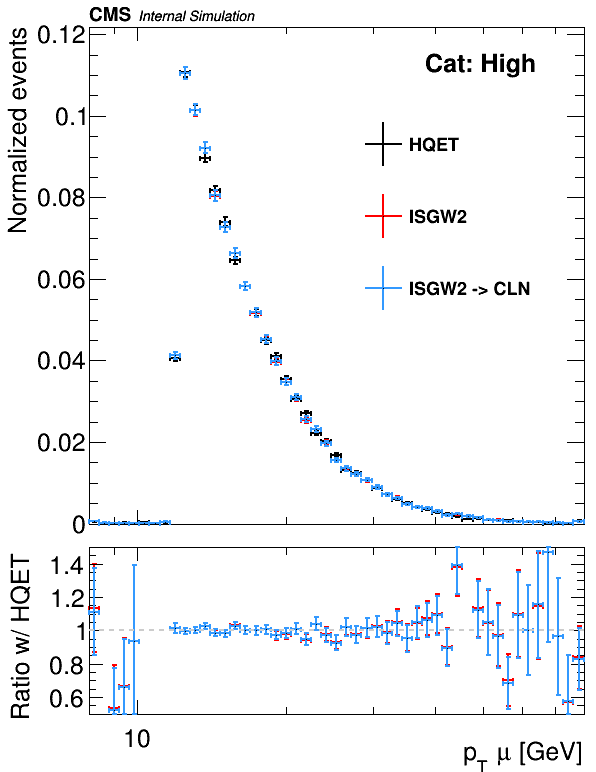

In [20]:
x = dset['muHQET_0'].data[cat]['MC_mu_pt']
hHQET = create_TH1D(x, name='hHQET', title='HQET',
                axis_title=['p_{T} #mu [GeV]', 'Normalized events'],
                binning=np.logspace(np.log10(8),np.log10(80),50),
                scale_histo=1./x.shape[0],
                opt='overflow+underflow'
               )

x = dset['mu_0'].data[cat]['MC_mu_pt']
hISGW = create_TH1D(x, name='hISGW', title='ISGW2', binning=hHQET.binning, 
                    scale_histo=1./x.shape[0],
                    opt='overflow+underflow')
hISGW.SetLineColor(rt.kRed)

w = dset['mu_0'].data[cat]['wh_CLNCentral']
hISGW2HQET = create_TH1D(x, name='hISGW2HQET', title='ISGW2 -> CLN', binning=hHQET.binning, 
                         weights=w, scale_histo=1./np.sum(w),
                         opt='overflow+underflow'
                        )
hISGW2HQET.SetLineColor(rt.kAzure+1)

h_list = [hHQET, hISGW, hISGW2HQET]

cr = make_ratio_plot(h_list, title = "", label = "", in_tags = None, 
                     ratio_bounds = [0.5, 1.5], 
                     draw_opt = 'E1', 
                     leg_pos=[0.6,0.4,0.95,0.8])

cr.pad1.cd()
text.Draw()
CMS_lumi.CMS_lumi(cr.pad1, -1, 0)
cr.pad1.SetLogx()
cr.pad2.SetLogx()
cr.Draw()

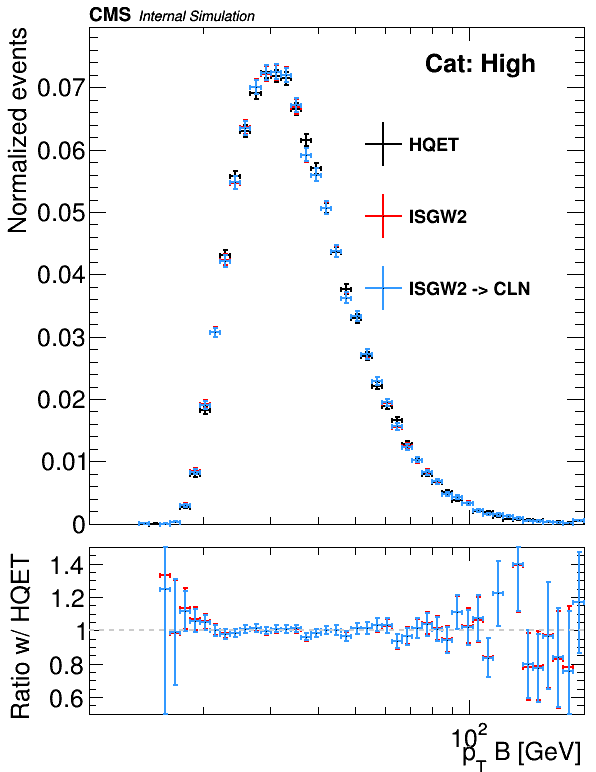

In [21]:
x = dset['muHQET_0'].data[cat]['MC_B_pt']
hHQET = create_TH1D(x, name='hHQET',
                title='HQET',
                axis_title=['p_{T} B [GeV]', 'Normalized events'],
                binning=np.logspace(np.log10(10),np.log10(200),50),
                scale_histo=1./x.shape[0],
                opt='overflow+underflow'
               )

x = dset['mu_0'].data[cat]['MC_B_pt']
hISGW = create_TH1D(x, name='hISGW', title='ISGW2', binning=hHQET.binning, 
                    scale_histo=1./x.shape[0],
                    opt='overflow+underflow')
hISGW.SetLineColor(rt.kRed)

w = dset['mu_0'].data[cat]['wh_CLNCentral']
hISGW2HQET = create_TH1D(x, name='hISGW2HQET', title='ISGW2 -> CLN', binning=hHQET.binning, 
                         weights=w, scale_histo=1./np.sum(w),
                         opt='overflow+underflow'
                        )
hISGW2HQET.SetLineColor(rt.kAzure+1)

h_list = [hHQET, hISGW, hISGW2HQET]

cr = make_ratio_plot(h_list, title = "", label = "", in_tags = None, 
                     ratio_bounds = [0.5, 1.5], 
                     draw_opt = 'E1', 
                     leg_pos=[0.6,0.4,0.95,0.8])

cr.pad1.cd()
text.Draw()
CMS_lumi.CMS_lumi(cr.pad1, -1, 0)
cr.pad1.SetLogx()
cr.pad2.SetLogx()
cr.Draw()

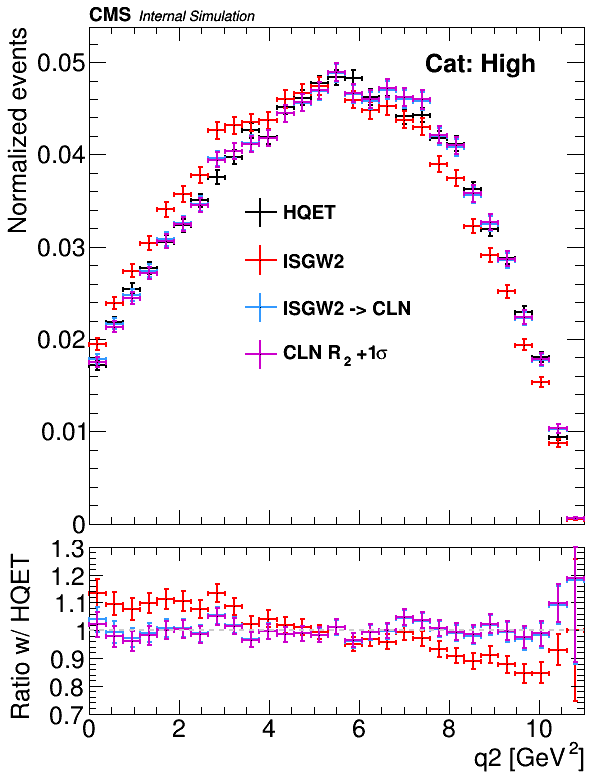

In [26]:
x = dset['muHQET_0'].data[cat]['MC_q2']
hHQET = create_TH1D(x, name='hHQET',
                title='HQET',
                axis_title=['q2 [GeV^{2}]', 'Normalized events'],
                binning=np.linspace(0,11,30),
                scale_histo=1./x.shape[0],
                opt='overflow+underflow'
               )

x = dset['mu_0'].data[cat]['MC_q2']
hISGW = create_TH1D(x, name='hISGW', title='ISGW2', binning=hHQET.binning, 
                    scale_histo=1./x.shape[0],
                    opt='overflow+underflow')
hISGW.SetLineColor(rt.kRed)

w = dset['mu_0'].data[cat]['wh_CLNCentral']
hISGW2HQET = create_TH1D(x, name='hISGW2HQET', title='ISGW2 -> CLN', binning=hHQET.binning, 
                         weights=w, scale_histo=1./np.sum(w),
                         opt='overflow+underflow'
                        )
hISGW2HQET.SetLineColor(rt.kAzure+1)

w = dset['mu_0'].data[cat]['wh_CLNR2Up']
h3 = create_TH1D(x, name='hISGW2HQET', title='CLN R_{2} +1#sigma', binning=hHQET.binning, 
                 weights=w, scale_histo=1./np.sum(w),
                 opt='overflow+underflow'
                )
h3.SetLineColor(rt.kMagenta+1)

h_list = [hHQET, hISGW, hISGW2HQET, h3]

cr = make_ratio_plot(h_list, title = "", label = "", in_tags = None, 
                     ratio_bounds = [0.7, 1.3], 
                     draw_opt = 'E1', 
                     leg_pos=[0.4,0.3,0.7,0.65])

cr.pad1.cd()
text.Draw()
CMS_lumi.CMS_lumi(cr.pad1, -1, 0)
cr.Draw()

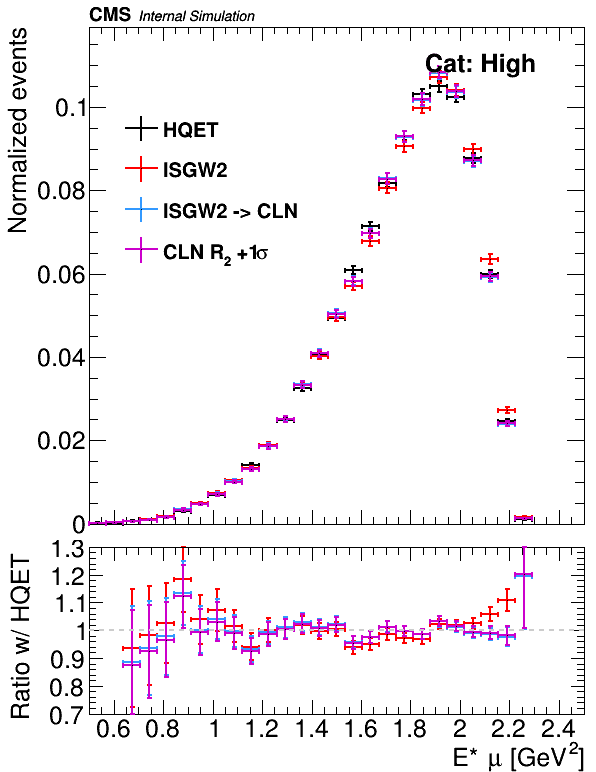

In [32]:
x = dset['muHQET_0'].data[cat]['MC_Est_mu']
hHQET = create_TH1D(x, name='hHQET',
                title='HQET',
                axis_title=['E* #mu [GeV^{2}]', 'Normalized events'],
                binning=np.linspace(0.5,2.5,30),
                scale_histo=1./x.shape[0],
                opt='overflow+underflow'
               )

x = dset['mu_0'].data[cat]['MC_Est_mu']
hISGW = create_TH1D(x, name='hISGW', title='ISGW2', binning=hHQET.binning, 
                    scale_histo=1./x.shape[0],
                    opt='overflow+underflow')
hISGW.SetLineColor(rt.kRed)

w = dset['mu_0'].data[cat]['wh_CLNCentral']
hISGW2HQET = create_TH1D(x, name='hISGW2HQET', title='ISGW2 -> CLN', binning=hHQET.binning, 
                         weights=w, scale_histo=1./np.sum(w),
                         opt='overflow+underflow'
                        )
hISGW2HQET.SetLineColor(rt.kAzure+1)

w = dset['mu_0'].data[cat]['wh_CLNR2Up']
h3 = create_TH1D(x, name='hISGW2HQET', title='CLN R_{2} +1#sigma', binning=hHQET.binning, 
                 weights=w, scale_histo=1./np.sum(w),
                 opt='overflow+underflow'
                )
h3.SetLineColor(rt.kMagenta+1)

h_list = [hHQET, hISGW, hISGW2HQET, h3]

cr = make_ratio_plot(h_list, title = "", label = "", in_tags = None, 
                     ratio_bounds = [0.7, 1.3], 
                     draw_opt = 'E1', 
                     leg_pos=[0.2,0.5,0.5,0.8])

cr.pad1.cd()
text.Draw()
CMS_lumi.CMS_lumi(cr.pad1, -1, 0)
cr.Draw()

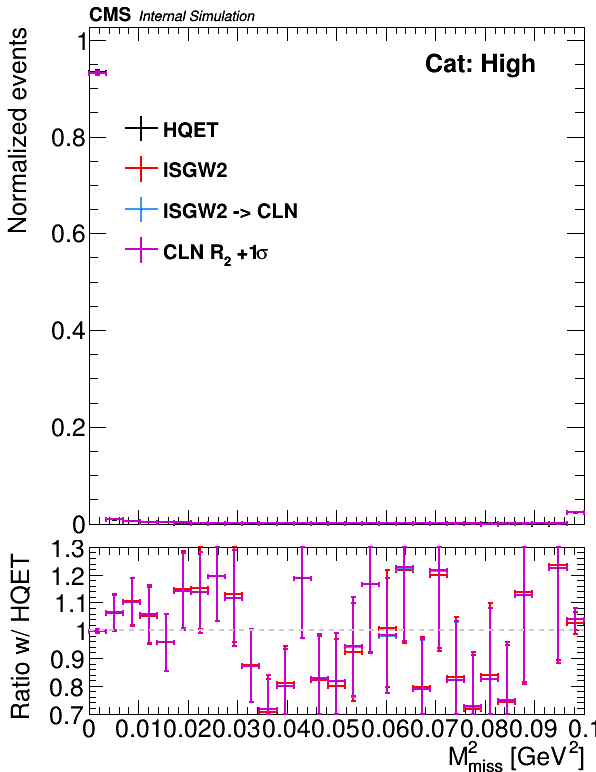

In [37]:
x = dset['muHQET_0'].data[cat]['MC_M2_miss']
hHQET = create_TH1D(x, name='hHQET',
                title='HQET',
                axis_title=['M^{2}_{miss} [GeV^{2}]', 'Normalized events'],
                binning=np.linspace(0,0.1,30),
                scale_histo=1./x.shape[0],
                opt='overflow+underflow'
               )

x = dset['mu_0'].data[cat]['MC_M2_miss']
hISGW = create_TH1D(x, name='hISGW', title='ISGW2', binning=hHQET.binning, 
                    scale_histo=1./x.shape[0],
                    opt='overflow+underflow')
hISGW.SetLineColor(rt.kRed)

w = dset['mu_0'].data[cat]['wh_CLNCentral']
hISGW2HQET = create_TH1D(x, name='hISGW2HQET', title='ISGW2 -> CLN', binning=hHQET.binning, 
                         weights=w, scale_histo=1./np.sum(w),
                         opt='overflow+underflow'
                        )
hISGW2HQET.SetLineColor(rt.kAzure+1)

w = dset['mu_0'].data[cat]['wh_CLNR2Up']
h3 = create_TH1D(x, name='hISGW2HQET', title='CLN R_{2} +1#sigma', binning=hHQET.binning, 
                 weights=w, scale_histo=1./np.sum(w),
                 opt='overflow+underflow'
                )
h3.SetLineColor(rt.kMagenta+1)

h_list = [hHQET, hISGW, hISGW2HQET, h3]

cr = make_ratio_plot(h_list, title = "", label = "", in_tags = None, 
                     ratio_bounds = [0.7, 1.3], 
                     draw_opt = 'E1', 
                     leg_pos=[0.2,0.5,0.5,0.8])

cr.pad1.cd()
text.Draw()
CMS_lumi.CMS_lumi(cr.pad1, -1, 0)
cr.Draw()